# Step #1 Load the Data

In [1]:
#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/007%20Time%20Series%20Forecasting%20-%20Multivariate%20Time%20Series%20Models.ipynb
#https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf

from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from tensorflow.keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
# sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import joblib

In [4]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='SET50'

start_date='2009-01-01'
end_date='2022-12-31'

#How much ratio to split
train_ratio=0.8

way=1

split_way=2

date_col='Date'
prediction_col='Price'
#feature_cols=['Price','EMA1']
feature_cols=['Price', 'EMA1', 'MACD', 'RSI']


# prediction_col='MACD'
# feature_cols=['MACD', 'SIGNAL','RSI-MA']

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 44



epochs =50
batch_size = 32
n_early=0


In [9]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2670 entries, 2012-01-04 to 2022-12-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2670 non-null   float64
 1   EMA1    2670 non-null   float64
 2   MACD    2670 non-null   float64
 3   RSI     2670 non-null   float64
dtypes: float64(4)
memory usage: 104.3 KB
None


,Price,EMA1,MACD,RSI
Date,,,,
2022-12-09,979.01,983.19,-0.43,46.93
2022-12-13,981.17,982.82,-0.56,48.86
2022-12-14,984.70,983.16,-0.34,51.92
2022-12-15,978.58,982.33,-0.71,46.72
2022-12-16,980.24,981.95,-0.82,48.23


# Step #2 Exploring the Data

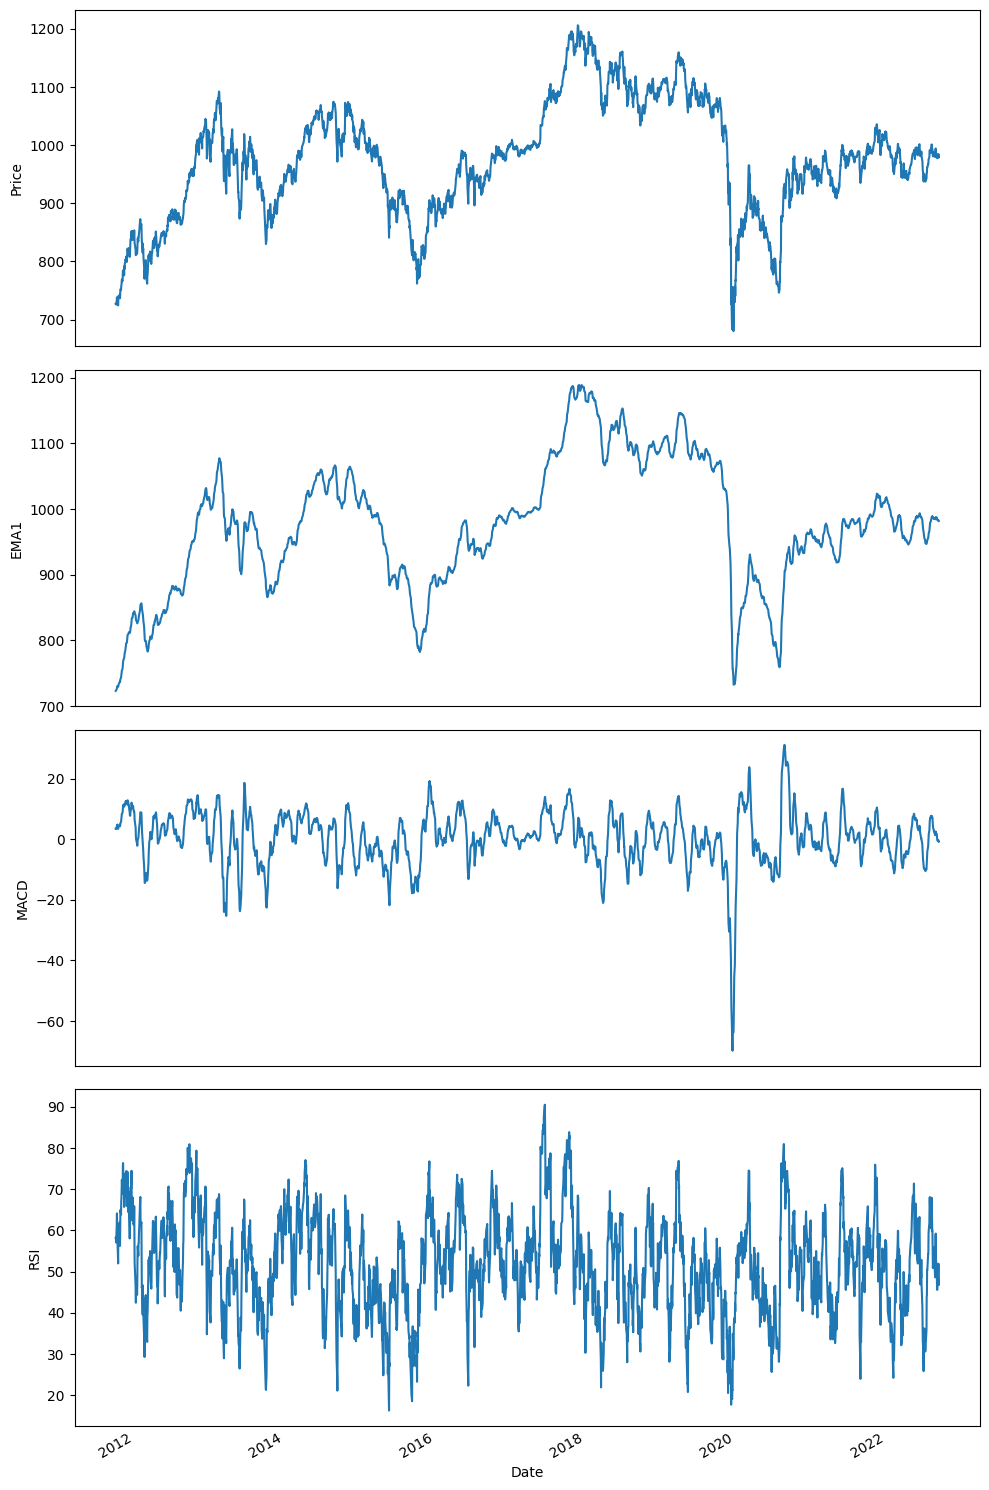

In [10]:
# Plot line charts
df_plot = df.copy()

ncols = 1
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(10, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [11]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES =feature_cols

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[prediction_col]

# Print the tail of the dataframe
print(data_filtered.shape)
print(data_filtered.tail())
print(data_filtered_ext.shape)
print(data_filtered_ext.tail())

FEATURE LIST
['Price', 'EMA1', 'MACD', 'RSI']
(2670, 4)
             Price    EMA1  MACD    RSI
Date                                   
2022-12-09  979.01  983.19 -0.43  46.93
2022-12-13  981.17  982.82 -0.56  48.86
2022-12-14  984.70  983.16 -0.34  51.92
2022-12-15  978.58  982.33 -0.71  46.72
2022-12-16  980.24  981.95 -0.82  48.23
(2670, 5)
             Price    EMA1  MACD    RSI  Prediction
Date                                               
2022-12-09  979.01  983.19 -0.43  46.93      979.01
2022-12-13  981.17  982.82 -0.56  48.86      981.17
2022-12-14  984.70  983.16 -0.34  51.92      984.70
2022-12-15  978.58  982.33 -0.71  46.72      978.58
2022-12-16  980.24  981.95 -0.82  48.23      980.24


In [12]:
nrows = data_filtered.shape[0]
print(f"Get the number of rows in the data {nrows}")

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)



Get the number of rows in the data 2670
(2670, 4)


# Split the training data into train and train data sets

In [13]:
index_Close = data.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Close}")

train_data_len = math.ceil(np_data_unscaled.shape[0] * train_ratio)
print(f"The number of rows to train the model on  {train_ratio } of the data = {train_data_len}")

Prediction Index = 0
The number of rows to train the model on  0.8 of the data = 2136


# Transform the data by scaling each feature to a range between 0 and 1

In [14]:

scaler = MinMaxScaler()
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
#scaler= RobustScaler()



if split_way==1:
    print("Way#1 scale entire data and split data")
    np_data_scaled = scaler.fit_transform(np_data_unscaled)    
    
    
    df_PredictVal = pd.DataFrame(data_filtered_ext[prediction_col])
    np_PredictVal_scaled = scaler_pred.fit_transform(df_PredictVal)
    
    print(np_data_scaled.shape,np_PredictVal_scaled)
    print(np_data_scaled[:5],np_PredictVal_scaled[:5])
    
    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]



else:
    print("#Way#2 split data and apply  only train to scale")
    
    train_data = np_data_unscaled[0:train_data_len, :]
    test_data = np_data_unscaled[train_data_len - sequence_length:, :]
    
    train_data=scaler.fit_transform(train_data)
    test_data=scaler.transform(test_data)
        
    df_PredictVal=data_filtered_ext.iloc[0:train_data_len][[prediction_col]]
    np_PredictVal_scaled = scaler_pred.fit_transform(df_PredictVal)
print("============================================")    
print("Scaled data completely")

print(f"{scaler.data_min_}  - {scaler.data_max_}") 

print("train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:3])
print(test_data[:3])

print("predict val data")
print(np_PredictVal_scaled.shape)
print(np_PredictVal_scaled[:3])

#Way#2 split data and apply  only train to scale
Scaled data completely
[680.07 723.1  -69.78  16.28]  - [1206.31 1188.88   23.78   90.51]
train and test data
(2136, 4) (578, 4)
[[0.08916084 0.         0.78345447 0.56459652]
 [0.08940787 0.00156726 0.78366823 0.56553954]
 [0.08669048 0.00229722 0.78174434 0.54950829]]
[[0.3979363  0.36233844 0.73011971 0.43365216]
 [0.40025464 0.36188759 0.73054724 0.44038798]
 [0.37137048 0.35557559 0.71707995 0.36467735]]
predict val data
(2136, 1)
[[0.08916084]
 [0.08940787]
 [0.08669048]]


In [15]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

print(x_test[:2])
print(y_test[:2])

(2092, 44, 4) (2092,)
(534, 44, 4) (534,)
0.2484037701429005
0.2484037701429005
[[[0.3979363  0.36233844 0.73011971 0.43365216]
  [0.40025464 0.36188759 0.73054724 0.44038798]
  [0.37137048 0.35557559 0.71707995 0.36467735]
  [0.36359836 0.34881274 0.70371954 0.34595177]
  [0.33074263 0.33653227 0.67870885 0.27414792]
  [0.34757905 0.32996264 0.66941    0.3297858 ]
  [0.32798723 0.32053759 0.65444634 0.28856258]
  [0.34252432 0.3158358  0.65188115 0.33584804]
  [0.35234874 0.31398944 0.65647713 0.36683282]
  [0.34961234 0.31190691 0.66011116 0.360097  ]
  [0.33598738 0.30741981 0.65765284 0.32641789]
  [0.33036257 0.30258921 0.65455323 0.31281153]
  [0.35478109 0.30366267 0.66577597 0.39781759]
  [0.37745135 0.3091803  0.68651133 0.46638825]
  [0.34892825 0.3078492  0.68896965 0.38933046]
  [0.34429158 0.30580961 0.68961094 0.37761013]
  [0.35685239 0.30671132 0.69709277 0.41721676]
  [0.32399666 0.3006999  0.68747328 0.33517446]
  [0.30444284 0.29176865 0.67186832 0.29300822]
  [0.304

# Step #4 Model Training

In [17]:
# Configure the neural network model

tf.random.set_seed(7)

model = Sequential()


n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

if way==1:
    model.add(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
elif way==2:
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))

else:
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(Dropout(0.2))
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dropout(0.2))
    
model.add(Dense(1))

print(f"Way={way} : Model with {n_neurons} = {x_train.shape[1]} inputshape Timestamps x {x_train.shape[2]} variables")

# Compile the model
# model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam',loss='mean_squared_error')

176 44 4
Way=1 : Model with 176 = 44 inputshape Timestamps x 4 variables


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 176)               127424    
                                                                 
 dense (Dense)               (None, 1)                 177       
                                                                 
Total params: 127,601
Trainable params: 127,601
Non-trainable params: 0
_________________________________________________________________


In [19]:

if n_early==0:
    print("Training the model")
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,shuffle=False,
                        validation_data=(x_test, y_test)
                       )
else:
    print(f"Training the model with EarlyStop = {n_early}")
    early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,shuffle=False,
                        validation_data=(x_test, y_test),
                       callbacks=[early_stop])

Training the model
Epoch 1/50
66/66 [==============================] - 5s 50ms/step - loss: 0.0153 - val_loss: 0.0028
Epoch 2/50
66/66 [==============================] - 3s 40ms/step - loss: 0.0036 - val_loss: 9.1794e-04
Epoch 3/50
66/66 [==============================] - 3s 39ms/step - loss: 0.0019 - val_loss: 7.0929e-04
Epoch 4/50
66/66 [==============================] - 3s 39ms/step - loss: 0.0013 - val_loss: 7.0874e-04
Epoch 5/50
66/66 [==============================] - 3s 39ms/step - loss: 0.0010 - val_loss: 7.9246e-04
Epoch 6/50
66/66 [==============================] - 3s 39ms/step - loss: 9.4738e-04 - val_loss: 8.5143e-04
Epoch 7/50
66/66 [==============================] - 3s 39ms/step - loss: 9.3705e-04 - val_loss: 8.3003e-04
Epoch 8/50
66/66 [==============================] - 3s 38ms/step - loss: 9.0383e-04 - val_loss: 7.5096e-04
Epoch 9/50
66/66 [==============================] - 3s 39ms/step - loss: 8.5625e-04 - val_loss: 6.6839e-04
Epoch 10/50
66/66 [=======================

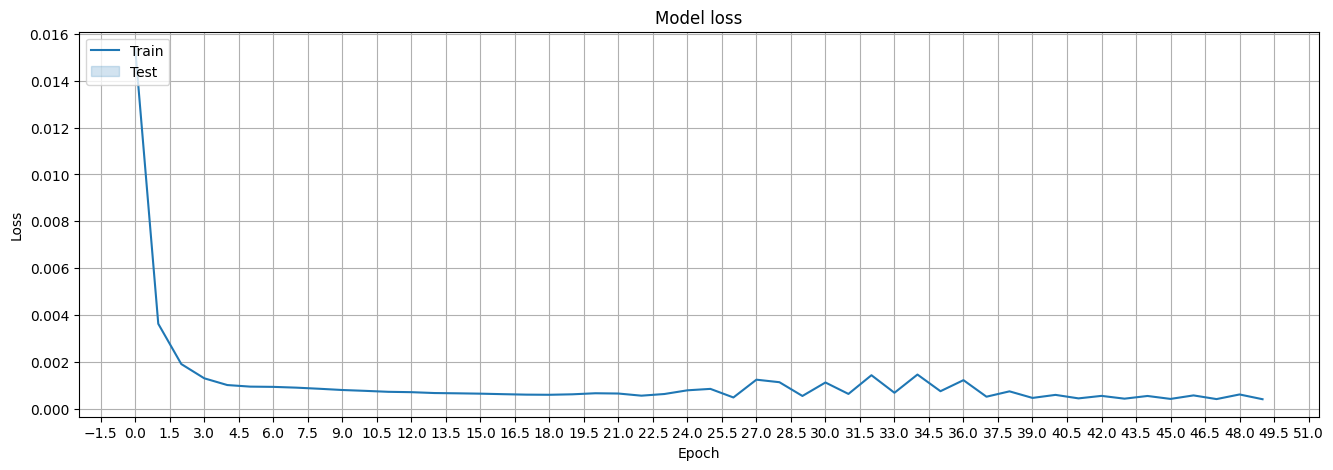

In [20]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

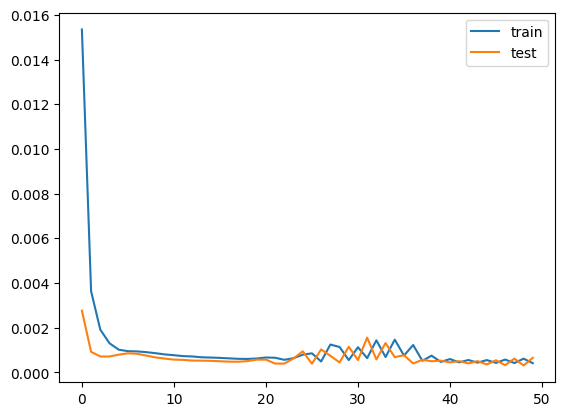

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Save model and scaler

In [22]:
print("Save model and scaler")

file_model='Model_ExplainMultiVarToOne.h5'
file_scaler='Scaler_ExplainMultiVarToOne.gz'
file_scaler_pred='ScalerPred_ExplainMultiVarToOne.gz'

model.save(file_model)
joblib.dump(scaler,file_scaler)
joblib.dump(scaler_pred,file_scaler_pred)

Save model and scaler


['ScalerPred_ExplainMultiVarToOne.gz']

# Step #5 Evaluate Model Performance

In [23]:
print("Load model and scaler")
x_model = load_model(file_model)
x_scaler = joblib.load(file_scaler)
x_scalerPred=joblib.load(file_scaler_pred)

Load model and scaler


In [24]:
# Get the predicted values
y_pred_scaled = x_model.predict(x_test)
print(y_pred_scaled.shape)
y_pred_scaled[:1]


17/17 [==============================] - 1s 16ms/step
(534, 1)


array([[0.22436197]], dtype=float32)

In [25]:
# Unscale the predicted values
y_pred = x_scalerPred.inverse_transform(y_pred_scaled)
y_test_unscaled = x_scalerPred.inverse_transform(y_test.reshape(-1, 1))

print(y_pred.shape)
print(y_pred[:1])

print(y_test_unscaled.shape)
print(y_test_unscaled[:1])

(534, 1)
[[798.13824]]
(534, 1)
[[796.43]]


In [26]:
RMSE = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root MEAN Square Error(RMSE): 13.41
Median Absolute Error (MAE): 11.26
Mean Absolute Percentage Error (MAPE): 1.17 %
Median Absolute Percentage Error (MDAPE): 1.08 %


In [27]:

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext[prediction_col][:train_data_len + 1]).rename(columns={prediction_col: 'y_train'})
valid = pd.DataFrame(data_filtered_ext[prediction_col][train_data_len:]).rename(columns={prediction_col: 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union.tail()

,y_train,y_test,residuals,y_pred
Date,,,,
2022-12-09,NaN,979.01,-15.133962,963.876038
2022-12-13,NaN,981.17,-13.468035,967.701965
2022-12-14,NaN,984.70,-13.055225,971.644775
2022-12-15,NaN,978.58,-1.874434,976.705566
2022-12-16,NaN,980.24,-14.349131,965.890869


In [28]:
df_union.head()

,y_train,y_test,residuals,y_pred
Date,,,,
2012-01-04,726.99,NaN,NaN,NaN
2012-01-05,727.12,NaN,NaN,NaN
2012-01-06,725.69,NaN,NaN,NaN
2012-01-09,732.21,NaN,NaN,NaN
2012-01-10,738.13,NaN,NaN,NaN


In [29]:
# The date from which on the date is displayed
display_start_date = "2021-01-01" 
df_union_zoom = df_union[df_union.index > display_start_date]
print(df_union_zoom.tail())

            y_train  y_test  residuals      y_pred
Date                                              
2022-12-09      NaN  979.01 -15.133962  963.876038
2022-12-13      NaN  981.17 -13.468035  967.701965
2022-12-14      NaN  984.70 -13.055225  971.644775
2022-12-15      NaN  978.58  -1.874434  976.705566
2022-12-16      NaN  980.24 -14.349131  965.890869


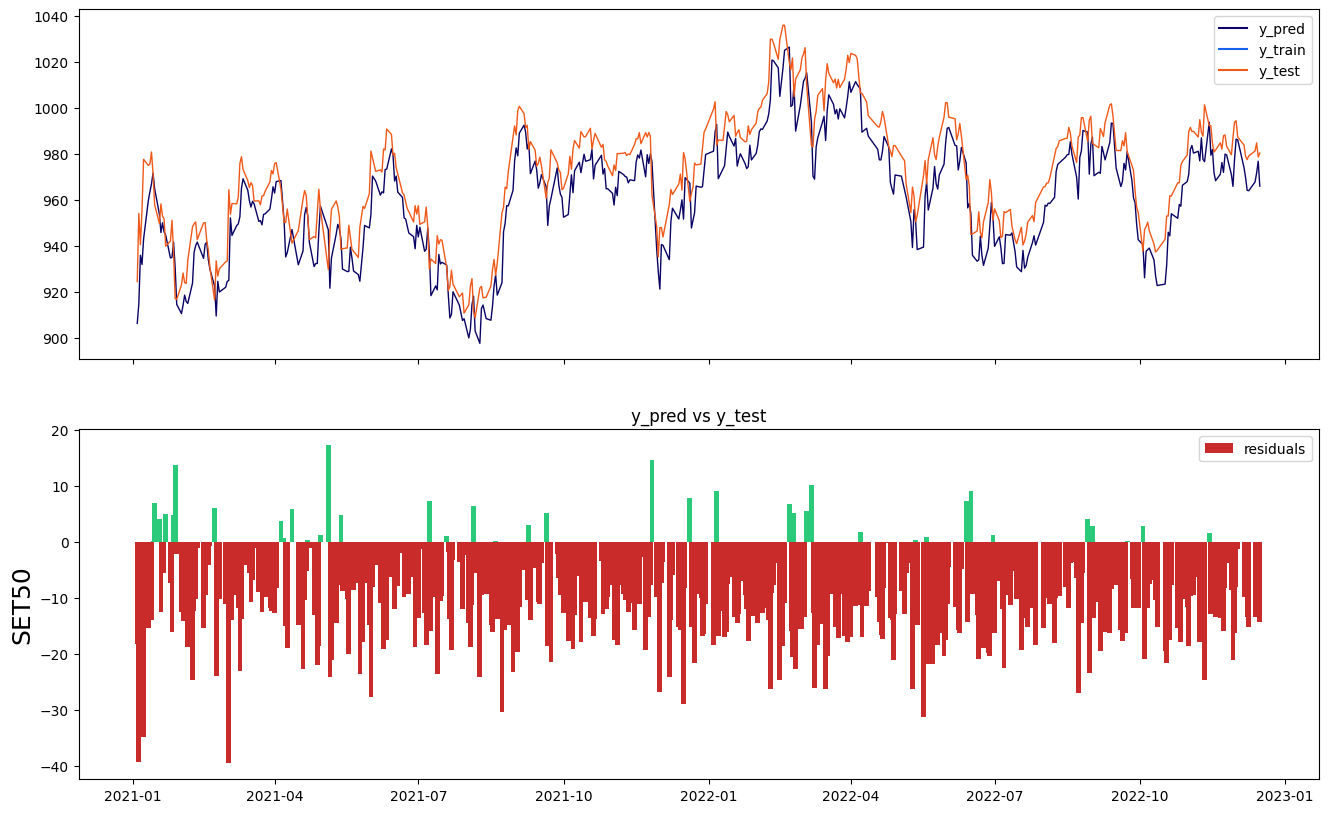

In [30]:
# Zoom in to a closer timeframe


# Create the lineplot
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(16, 10),sharex=True)
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax2.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Step #6 Predict Next Day's Price

In [31]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = x_scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = x_model.predict(np.array(X_test_new))
pred_price_unscaled = x_scalerPred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df[prediction_col][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 24ms/step
The close price for SET50 at 2022-12-31 was 980.24
The predicted close price is 968.469970703125 (-1.22%)


# Test Shap

In [32]:
#https://analyticsindiamag.com/a-guide-to-explaining-feature-importance-in-neural-networks-using-shap/
#https://slundberg.github.io/shap/notebooks/deep_explainer/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html
#https://www.kaggle.com/code/ltsmssv/shap-for-lstm-stock-v1/notebook

import shap
# Use the training data for deep explainer => can use fewer instances
explainer_ = shap.DeepExplainer(model, x_train)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [33]:
shap_values_ = explainer_.shap_values(x_test)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 378, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefex before the lookup
    File "D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 667, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 674, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 224, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer "lstm" "                 f"(type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer "lstm" "                 f"(type LSTM):
      • inputs=tf.Tensor(shape=(4184, 44, 4), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None
